## Load Data from CSVs

In [1]:
import unicodecsv

## Longer version of code (replaced with shorter, equivalent version below)

# enrollments = []
# f = open('enrollments.csv', 'rb')
# reader = unicodecsv.DictReader(f)
# for row in reader:
#     enrollments.append(row)
# f.close()
def load_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)
    
#####################################
#                 1                 #
#####################################

## Read in the data from daily_engagement.csv and project_submissions.csv 
## and store the results in the below variables.
## Then look at the first row of each table.

enrollments = load_csv('./data/enrollments.csv')
daily_engagement = load_csv('./data/daily_engagement.csv') 
project_submissions = load_csv('./data/project_submissions.csv')

## Fixing Data Types

In [2]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

OrderedDict([('account_key', '448'),
             ('status', 'canceled'),
             ('join_date', datetime.datetime(2014, 11, 10, 0, 0)),
             ('cancel_date', datetime.datetime(2015, 1, 14, 0, 0)),
             ('days_to_cancel', 65),
             ('is_udacity', True),
             ('is_canceled', True)])

In [3]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

OrderedDict([('acct', '0'),
             ('utc_date', datetime.datetime(2015, 1, 9, 0, 0)),
             ('num_courses_visited', 1),
             ('total_minutes_visited', 11.6793745),
             ('lessons_completed', 0),
             ('projects_completed', 0)])

In [4]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

OrderedDict([('creation_date', datetime.datetime(2015, 1, 14, 0, 0)),
             ('completion_date', datetime.datetime(2015, 1, 16, 0, 0)),
             ('assigned_rating', 'UNGRADED'),
             ('account_key', '256'),
             ('lesson_key', '3176718735'),
             ('processing_state', 'EVALUATED')])

## Investigating the Data

In [5]:
#####################################
#                 2                 #
#####################################

## Find the total number of rows and the number of unique students (account keys)
## in each table.
def unique_stu(table, ans, para):
    for row in table:
        ans.add(row[para])
    return ans

print ('Enrollment: ', len(enrollments))
unique_stu_enroll = set()
unique_stu_enroll = unique_stu(enrollments, unique_stu_enroll, 'account_key')
print (len(unique_stu_enroll), '\n\n')

print ('Daily engagement: ', len(daily_engagement))
unique_stu_daily = set()
unique_stu_daily = unique_stu(daily_engagement, unique_stu_daily, 'acct')
print (len(unique_stu_daily), '\n\n')

print ('Project submission: ', len(project_submissions))
unique_stu_project = set()
unique_stu_project = unique_stu(project_submissions, unique_stu_project, 'account_key')
print (len(unique_stu_project))

Enrollment:  1640
1302 


Daily engagement:  136240
1237 


Project submission:  3642
743


## Problems in the Data

In [6]:
#####################################
#                 3                 #
#####################################

## Rename the "acct" column in the daily_engagement table to "account_key".
for row in daily_engagement:
    row['account_key'] = str(row['acct'])
    del row['acct']
    
daily_engagement[0]

OrderedDict([('utc_date', datetime.datetime(2015, 1, 9, 0, 0)),
             ('num_courses_visited', 1),
             ('total_minutes_visited', 11.6793745),
             ('lessons_completed', 0),
             ('projects_completed', 0),
             ('account_key', '0')])

## Missing Engagement Records

In [7]:
#####################################
#                 4                 #
#####################################

## Find any one student enrollments where the student is missing from the daily engagement table.
## Output that enrollment.
missing_stu = []
for student in unique_stu_enroll:
    if student not in unique_stu_daily:
        missing_stu.append(student)

print ('Total missing student from daily engagement: ', len(missing_stu))
print ('They are: ', missing_stu)

Total missing student from daily engagement:  65
They are:  ['1129', '1284', '878', '841', '1101', '725', '727', '1219', '981', '1238', '1273', '870', '996', '1069', '1044', '1148', '1155', '1304', '1120', '799', '819', '1171', '1010', '707', '654', '1063', '964', '664', '802', '1190', '902', '803', '737', '739', '997', '1086', '711', '1191', '914', '817', '1270', '750', '1241', '728', '789', '968', '871', '884', '733', '749', '1025', '1218', '1291', '926', '1079', '1213', '1145', '1186', '717', '766', '1125', '1222', '889', '1237', '875']


## Tracking Down the Remaining Problems

In [8]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [9]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [42]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print (len(non_udacity_enrollments))
print (len(non_udacity_engagement))
print (len(non_udacity_submissions))

1622
135656
3634


OrderedDict([('creation_date', datetime.datetime(2015, 1, 14, 0, 0)),
             ('completion_date', datetime.datetime(2015, 1, 16, 0, 0)),
             ('assigned_rating', 'UNGRADED'),
             ('account_key', '256'),
             ('lesson_key', '3176718735'),
             ('processing_state', 'EVALUATED')])

## Refining the Question

In [11]:
#####################################
#                 6                 #
#####################################

## Create a dictionary named paid_students containing all students who either
## haven't canceled yet or who remained enrolled for more than 7 days. The keys
## should be account keys, and the values should be the date the student enrolled.
paid_students = dict()

for row in non_udacity_enrollments:
    if row['days_to_cancel'] is None or row['days_to_cancel'] > 7:      
        if row['account_key'] not in paid_students or row['join_date'] > paid_students[row['account_key']]:
            paid_students[row['account_key']] = row['join_date']
        
print (len(paid_students))

995


## Getting Data from First Week

In [12]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0

In [43]:
#####################################
#                 7                 #
#####################################

## Create a list of rows from the engagement table including only rows where
## the student is one of the paid students you just found, and the date is within
## one week of the student's join date.

paid_engagement_in_first_week = []

def remove_free_trial(data):
    new_data = []
    for dt in data:
        if dt['account_key'] in paid_students:
            new_data.append(dt)
            
    return new_data

paid_enrollment = remove_free_trial(non_udacity_enrollments)
paid_engaement = remove_free_trial(non_udacity_engagement)
paid_submissions = remove_free_trial(non_udacity_submissions)

for row in paid_engaement:
    if row['num_courses_visited'] > 0:
        row['has_visited'] = 1
    else:
        row['has_visited'] = 0

for student in paid_engaement:
    acc_key = student['account_key']
    join_date = paid_students[acc_key]
    eng_date = student['utc_date']
    
    if within_one_week(join_date, eng_date):
        paid_engagement_in_first_week.append(student)
    
print (len(paid_engagement_in_first_week))

6919


OrderedDict([('creation_date', datetime.datetime(2015, 1, 14, 0, 0)),
             ('completion_date', datetime.datetime(2015, 1, 16, 0, 0)),
             ('assigned_rating', 'UNGRADED'),
             ('account_key', '256'),
             ('lesson_key', '3176718735'),
             ('processing_state', 'EVALUATED')])

## Exploring Student Engagement

In [23]:
from collections import defaultdict

# Create a dictionary of engagement grouped by student.
# The keys are account keys, and the values are lists of engagement records.
engagement_by_account = defaultdict(list)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    engagement_by_account[account_key].append(engagement_record)

In [24]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)
total_minutes_by_account = {}
for account_key, engagement_for_student in engagement_by_account.items():
    total_minutes = 0
    for engagement_record in engagement_for_student:
        total_minutes += engagement_record['total_minutes_visited']
    total_minutes_by_account[account_key] = total_minutes

In [25]:
import numpy as np

# Summarize the data about minutes spent in the classroom
total_minutes = list(total_minutes_by_account.values())

print ('Mean:', np.mean(total_minutes))
print ('Standard deviation:', np.std(total_minutes))
print ('Minimum:', np.min(total_minutes))
print ('Maximum:', np.max(total_minutes))

Mean: 306.70832675342825
Standard deviation: 412.99693340852957
Minimum: 0.0
Maximum: 3564.7332644989997


## Debugging Data Analysis Code

In [26]:
#####################################
#                 8                 #
#####################################

## Go through a similar process as before to see if there is a problem.
## Locate at least one surprising piece of data, output it, and take a look at it.
student_max_minutes = None
max_minutes = 0

for student, total_minutes in total_minutes_by_account.items():
    if total_minutes > max_minutes:
        max_minutes = total_minutes
        student_max_minutes = student
        
for row in paid_engagement_in_first_week:
    if row['account_key'] == student_max_minutes:
        print (row)

OrderedDict([('utc_date', datetime.datetime(2015, 7, 9, 0, 0)), ('num_courses_visited', 4), ('total_minutes_visited', 850.519339666), ('lessons_completed', 4), ('projects_completed', 0), ('account_key', '163'), ('has_visited', 1)])
OrderedDict([('utc_date', datetime.datetime(2015, 7, 10, 0, 0)), ('num_courses_visited', 6), ('total_minutes_visited', 872.633923334), ('lessons_completed', 6), ('projects_completed', 0), ('account_key', '163'), ('has_visited', 1)])
OrderedDict([('utc_date', datetime.datetime(2015, 7, 11, 0, 0)), ('num_courses_visited', 2), ('total_minutes_visited', 777.018903666), ('lessons_completed', 6), ('projects_completed', 0), ('account_key', '163'), ('has_visited', 1)])
OrderedDict([('utc_date', datetime.datetime(2015, 7, 12, 0, 0)), ('num_courses_visited', 1), ('total_minutes_visited', 294.568774), ('lessons_completed', 2), ('projects_completed', 0), ('account_key', '163'), ('has_visited', 1)])
OrderedDict([('utc_date', datetime.datetime(2015, 7, 13, 0, 0)), ('num_c

## Lessons Completed in First Week

Mean: 1.636180904522613
Standard deviation: 3.002561299829423
Minimum: 0
Maximum: 36


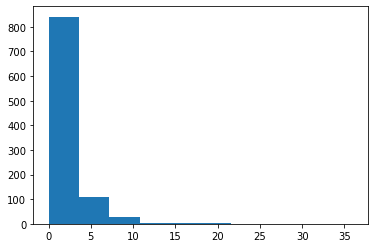

In [72]:
#####################################
#                 9                 #
#####################################

## Adapt the code above to find the mean, standard deviation, minimum, and maximum for
## the number of lessons completed by each student during the first week. Try creating
## one or more functions to re-use the code above.
def group_data(data, key_name):
    grouped_data = defaultdict(list)
    for row in data:
        key = row[key_name]
        grouped_data[key].append(row)
        
    return grouped_data

def total_grouped(grouped_data, field_name):
    total_data = {}
    
    for key, row in grouped_data.items():
        total = 0
        for value in row:
            total += value[field_name]
        total_data[key] = total
        
    return total_data

import matplotlib.pyplot as plt
def overview(data):
    print ('Mean:', np.mean(data))
    print ('Standard deviation:', np.std(data))
    print ('Minimum:', np.min(data))
    print ('Maximum:', np.max(data))
    plt.hist(data)
    
lesson_completed_by_account = total_grouped(engagement_by_account, 'lessons_completed')
overview(list(lesson_completed_by_account.values()))

## Number of Visits in First Week

Mean: 2.8673366834170855
Standard deviation: 2.2551980029196814
Minimum: 0
Maximum: 7


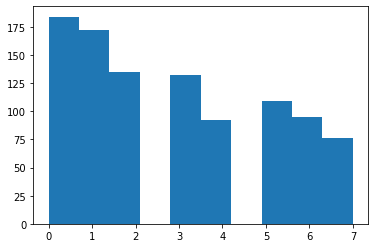

In [73]:
######################################
#                 10                 #
######################################

## Find the mean, standard deviation, minimum, and maximum for the number of
## days each student visits the classroom during the first week.
def sum_grouped_items (grouped_data, field_name):
    summed_data = {}
    
    for key, data in grouped_data.items():
        total = 0
        for dt in data:
            total += dt[field_name]
        summed_data[key] = total
        
    return summed_data

day_visited_by_account = sum_grouped_items (engagement_by_account, 'has_visited')

overview(list(day_visited_by_account.values()))

## Splitting out Passing Students

In [74]:
######################################
#                 11                 #
######################################

## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']

pass_subway_project = set()

for submission in paid_submissions:
    project = submission['lesson_key']
    rating = submission['assigned_rating']
    
    if project in subway_project_lesson_keys and (rating == 'PASSED' or rating == 'DISTINCTION'):
        pass_subway_project.add(submission['account_key'])

len(pass_subway_project)

647

In [75]:
passing_engagement = []
non_passing_engagement = []

for row in paid_engagement_in_first_week:
    if row['account_key'] in pass_subway_project:
        passing_engagement.append(row)
    else:
        non_passing_engagement.append(row)
        
print (len(passing_engagement))
print (len(non_passing_engagement))

4527
2392


## Comparing the Two Student Groups

In [76]:
######################################
#                 12                 #
######################################

## Compute some metrics you're interested in and see how they differ for
## students who pass the subway project vs. students who don't. A good
## starting point would be the metrics we looked at earlier (minutes spent
## in the classroom, lessons completed, and days visited).

passing_engagement_by_account = group_data(passing_engagement, 'account_key')
non_passing_engagement_by_account = group_data(non_passing_engagement, 'account_key')

Mean: 394.58604648350865
Standard deviation: 448.4995193265521
Minimum: 0.0
Maximum: 3564.7332644989997


Mean: 143.32647426675584
Standard deviation: 269.5386190114951
Minimum: 0.0
Maximum: 1768.5227493319999


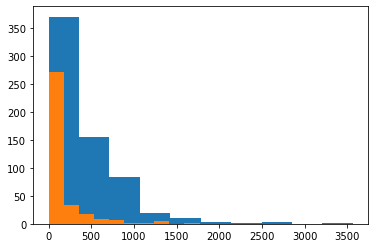

In [77]:
passing_minutes = sum_grouped_items(passing_engagement_by_account, 'total_minutes_visited')
overview(list(passing_minutes.values()))

print ('\n')

non_passing_minutes = sum_grouped_items(non_passing_engagement_by_account, 'total_minutes_visited')
overview(list(non_passing_minutes.values()))

# Quick Result Observation

_ Passing students spent over twice amount of time than non-passing ones. There is a wide range of passing students types, which can be seen from minimum and SD of passing students.

## Improving Plots and Sharing Findings

Text(0.5, 1.0, 'Distribution of classroom minutes in the first week')

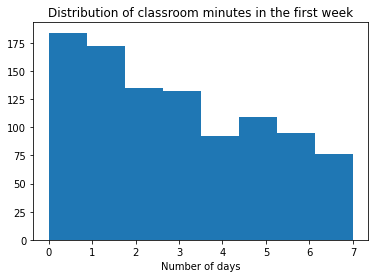

In [80]:
######################################
#                 14                 #
######################################

## Make a more polished version of at least one of your visualizations
## from earlier. Try importing the seaborn library to make the visualization
## look better, adding axis labels and a title, and changing one or more
## arguments to the hist() function.
import seaborn as sns

plt.hist(list(day_visited_by_account.values()), bins = 8)
plt.xlabel('Number of days')
plt.title('Distribution of classroom  in the first week')